In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
file_path=r'C:\Users\bhavrang\Documents\Analytics vidhya\GlobalDataChallenge-II\global_data_science_challenge_2_public-master/data/gdsc2_public.csv'
df=pd.read_csv(file_path, sep=';', parse_dates=['timestamp'])
df=df.sort_values(by=['work_item','timestamp'])

In [3]:
df['from_phase'].fillna('Start',inplace=True)
df['to_phase'].fillna('End',inplace=True)
df.components.fillna('NA',inplace=True)

In [70]:
df.to_resource.fillna('',inplace=True)
df.from_resource.fillna('',inplace=True)

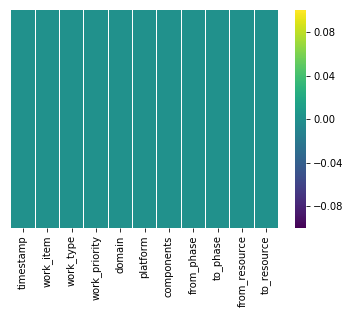

In [71]:
sns.heatmap(df.isnull(),yticklabels=False,cmap='viridis')

In [72]:
def aggregation(x):
    names={'was_closed': max(x['to_phase'] == 'End'),
            'nr_of_phases': len(x),  # Not counting the start phase
            'unique_phases': x['from_phase'].nunique()  # Not counting the end phase
        }
    return pd.Series(names)

In [73]:
df_workitem_agg = df.groupby('work_item').apply(aggregation)

In [74]:
df_workitem_agg['was_closed'].value_counts()

True     10522
False     1042
Name: was_closed, dtype: int64

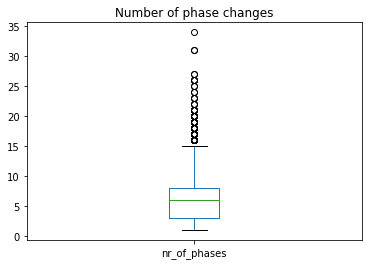

In [8]:
df_workitem_agg.plot(kind='box', y='nr_of_phases', title='Number of phase changes')

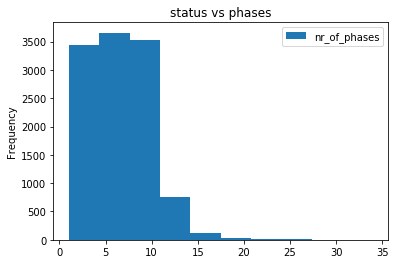

In [59]:
df_workitem_agg.plot(kind='hist',x='was_closed',y='nr_of_phases',title='status vs phases')

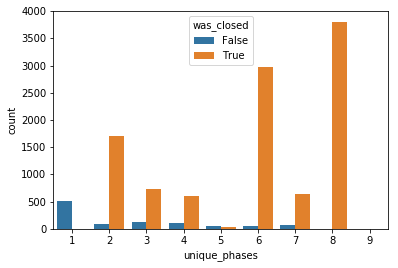

In [60]:
sns.countplot(data=df_workitem_agg,x='unique_phases',hue='was_closed')

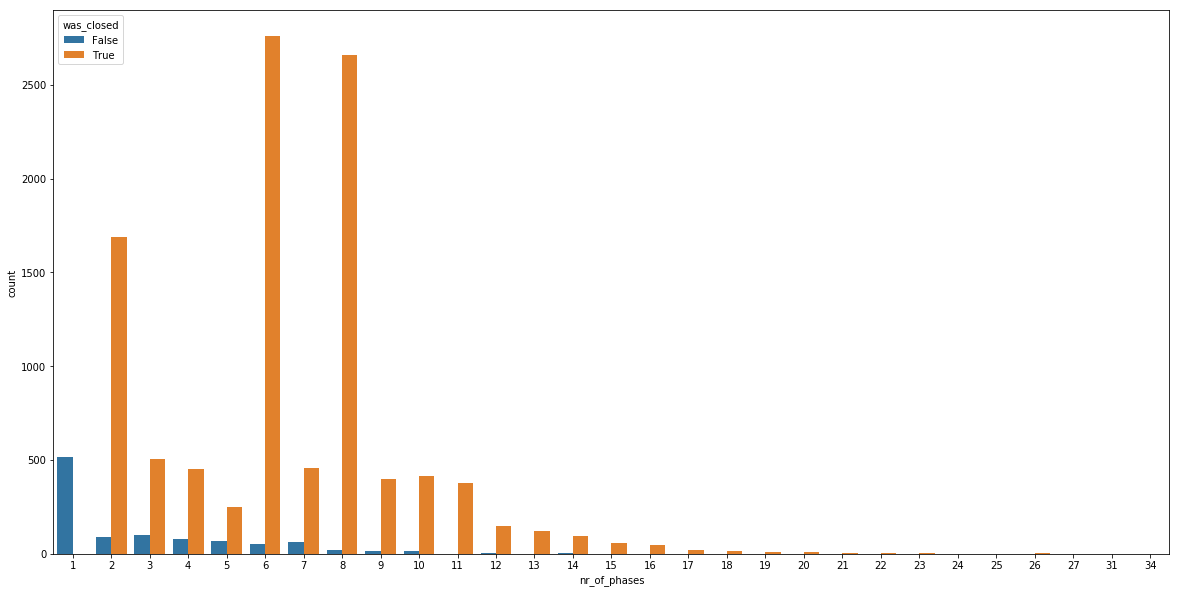

In [61]:
fig, axs = plt.subplots(ncols=1,figsize=(20, 10))
sns.countplot(data=df_workitem_agg,x='nr_of_phases',hue='was_closed')

In [75]:
start_times=df[df['from_phase']=='Start'][['work_item','timestamp']]
end_times=df[df['to_phase']=='End'][['work_item','timestamp']]
times=pd.merge(start_times,end_times,on='work_item',how='left')
times['duration']=times['timestamp_y']-times['timestamp_x']
times['duration_in_days'] = times['duration'].apply(lambda x: round(x.total_seconds() / (24*3600), 2))
times.head()

,work_item,timestamp_x,timestamp_y,duration,duration_in_days
0,WI_000001,2015-01-02 14:39:14,2015-01-27 11:36:51,24 days 20:57:37,24.87
1,WI_000002,2015-01-02 15:04:20,2015-01-14 09:46:37,11 days 18:42:17,11.78
2,WI_000003,2015-01-02 15:28:22,2015-02-26 11:50:37,54 days 20:22:15,54.85
3,WI_000004,2015-01-02 15:33:54,2015-01-28 09:11:05,25 days 17:37:11,25.73
4,WI_000005,2015-01-02 16:32:11,2015-02-04 12:57:49,32 days 20:25:38,32.85


In [76]:
finished_times=times[times['duration'].notnull()]

In [77]:
times[times['duration_in_days'].apply(lambda x:x<1)]['work_item'].count()

1403

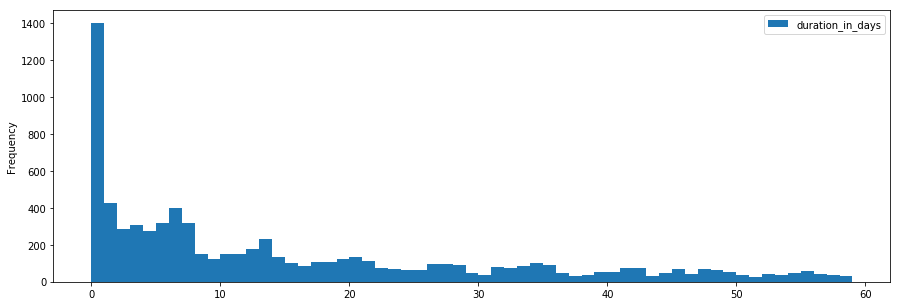

In [65]:
finished_times.plot(kind='hist',y='duration_in_days',bins=range(60),figsize=(15, 5))

In [78]:
open_per_day=times.resample('D',on='timestamp_x')['work_item'].count().rename('open_tickets_per_day')

In [79]:
is_closed = times['timestamp_y'].notnull()
closed_per_day = times.loc[is_closed].resample('D', on='timestamp_y')['work_item'].count().rename('closed_tickets_per_day')


In [80]:
tickets_df = (pd.concat([open_per_day, closed_per_day], axis=1) # Join the two dataframes
                .fillna(0)                                      # Replace NaNs by 0 for those days when no tickets are opened or closed
                .astype(int)                                    # While we're at it, all counts are integers
                .reset_index()                                  # timestamp_x is used as index, move it back to a column
                .rename(columns={'timestamp_x': 'date'})        # and rename it to ‘date’
             )


In [15]:
tickets_df.head()

,date,open_tickets_per_day,closed_tickets_per_day
0,2015-01-02,6,0
1,2015-01-03,1,0
2,2015-01-04,2,0
3,2015-01-05,22,0
4,2015-01-06,17,7


In [81]:
tickets_df['open_tickets_total'] = tickets_df['open_tickets_per_day'].cumsum()
tickets_df['closed_tickets_total'] = tickets_df['closed_tickets_per_day'].cumsum()
tickets_df['wip_tickets_total'] = tickets_df['open_tickets_total'] - tickets_df['closed_tickets_total']

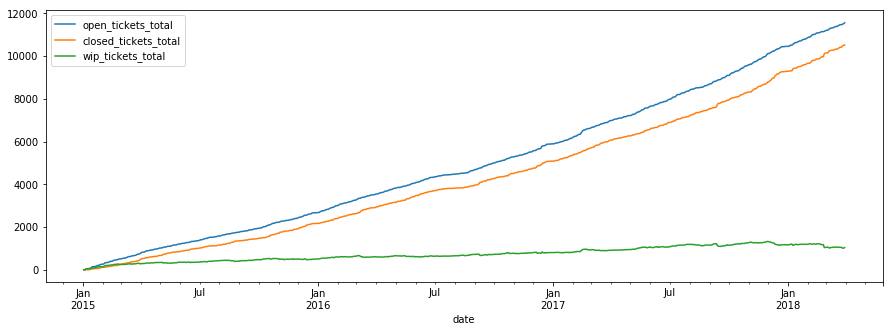

In [71]:
tickets_df.plot(x='date', y=['open_tickets_total', 'closed_tickets_total', 'wip_tickets_total'] , figsize=(15, 5))

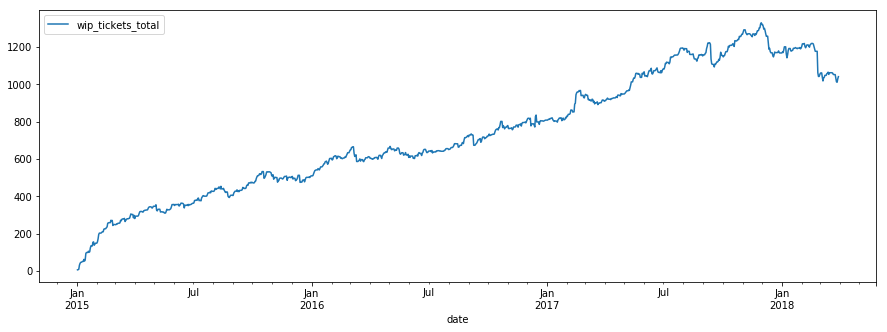

In [72]:
tickets_df.plot(x='date', y=['wip_tickets_total'] , figsize=(15, 5))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000027A57B1FC88>,
      dtype=object)

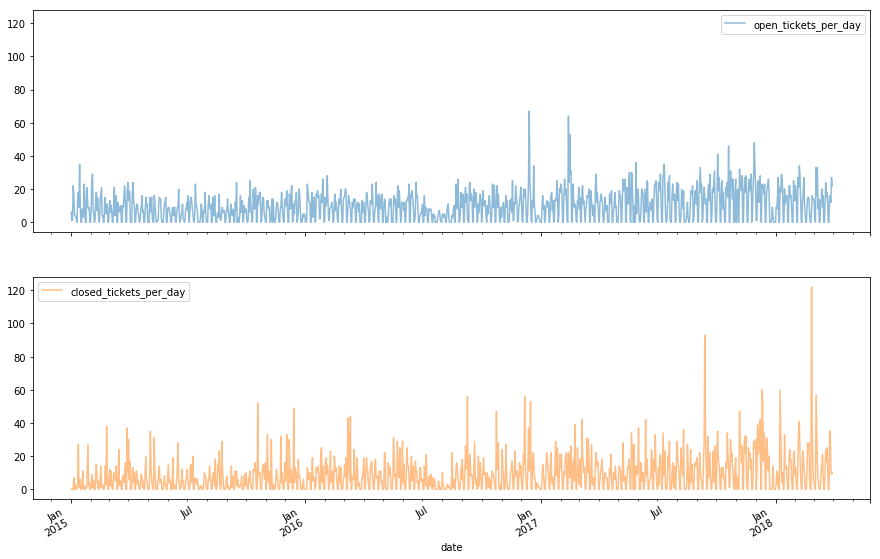

In [73]:
tickets_df.plot(x='date', y=['open_tickets_per_day', 'closed_tickets_per_day'] , 
                figsize=(15, 10), subplots=True, alpha=0.5, sharey=True)

In [17]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import OneHotEncoder

In [82]:
times_open=times[times['duration'].isnull()]
times_closed=times[times['duration'].notnull()]

In [83]:
times.rename(columns={'timestamp_x': 'start', 'timestamp_y': 'end'}, inplace=True)

In [20]:
def rmsle(actuals: pd.DataFrame, predictions: pd.DataFrame) -> float:
    """
    Computes the root mean square log error between the actuals and predictions.
    Raises and error if there are multiple predictions for a single work item, or if there are missing predictions
    :param actuals: A DataFrame with the columns 'work_item' and 'duration_in_days'
    :param predictions: A DataFrame with the columns 'work_item' and 'predictions'
    :return: RMSLE between actuals and predictions
    """
    assert len(actuals) == len(predictions)
    assert set(actuals.work_item.values) == set(predictions.work_item.values)
    actuals_values = actuals.duration_in_days.values
    predictions_values = predictions.predictions.values
    rmsle = np.sqrt(sum(((np.log(actuals_values + 1) - np.log(predictions_values + 1)) ** 2)) / len(actuals_values))
    return rmsle

In [21]:
import datetime as dt

In [84]:
closed_times = times[times['duration'].notnull()]
open_times = times[times['duration'].isnull()]

In [85]:
sep_date_str = '01.01.2018'
sep_date = dt.datetime.strptime(sep_date_str, '%d.%m.%Y')
train_times = closed_times[closed_times.end <= sep_date]
test_times = closed_times[(closed_times.end > sep_date) & (closed_times.start <= sep_date)]
test_times.head()

,work_item,start,end,duration,duration_in_days
196,WI_000197,2015-01-23 15:45:50,2018-02-09 13:54:39,1112 days 22:08:49,1112.92
435,WI_000436,2015-02-18 13:11:50,2018-02-01 16:53:59,1079 days 03:42:09,1079.15
518,WI_000519,2015-03-02 15:32:10,2018-01-09 11:37:11,1043 days 20:05:01,1043.84
910,WI_000911,2015-04-14 17:36:26,2018-02-12 07:21:15,1034 days 13:44:49,1034.57
1121,WI_001122,2015-05-19 10:23:47,2018-03-16 14:47:51,1032 days 04:24:04,1032.18


In [86]:
def aggregation(x):
    names = {
        'was_closed': max(x['to_phase'] == 'End'),
        'nr_of_resources': len(x),  # Not counting the start phase
        'unique_resources': x['from_resource'].nunique()  # Not counting the end phase
        }
    return pd.Series(names)

df_workitem_res_agg = df.groupby('work_item').apply(aggregation)
df_workitem_res_agg.head()

,was_closed,nr_of_resources,unique_resources
work_item,,,
WI_000001,True,12,4
WI_000002,True,4,2
WI_000003,True,8,2
WI_000004,True,8,4
WI_000005,True,8,4


In [87]:
train_work_items = set(train_times.work_item)  
test_work_items = set(test_times.work_item)  
df_start_only = df[df.from_phase == 'Start']
df_start_only=pd.merge(df_start_only,df_workitem_agg,on='work_item',how='left')
#df_start_only=pd.merge(df_start_only,df_workitem_res_agg,on='work_item',how='left')
train_df = df_start_only[df_start_only['work_item'].isin(train_work_items)]  
test_df = df_start_only[df_start_only['work_item'].isin(test_work_items)]

In [88]:
train_df.shape

(9290, 14)

In [27]:
from sklearn.preprocessing import OneHotEncoder

In [89]:
train_df.head()

,timestamp,work_item,work_type,work_priority,domain,platform,components,from_phase,to_phase,from_resource,to_resource,was_closed,nr_of_phases,unique_phases
0,2015-01-02 14:39:14,WI_000001,WT_00001,WP_00003,BD_00001,PL_00001,NA,Start,Analyze,,ER_00043,True,12,8
1,2015-01-02 15:04:20,WI_000002,WT_00002,WP_00004,BD_00002,PL_00002,CO_00037/CO_00071,Start,Analyze,,ER_00225,True,4,4
2,2015-01-02 15:28:22,WI_000003,WT_00002,WP_00004,BD_00002,PL_00002,CO_00037/CO_00071,Start,Analyze,,ER_00225,True,8,6
3,2015-01-02 15:33:54,WI_000004,WT_00002,WP_00004,BD_00002,PL_00002,CO_00037/CO_00071,Start,Analyze,,ER_00225,True,8,8
4,2015-01-02 16:32:11,WI_000005,WT_00002,WP_00003,BD_00003,PL_00003,CO_00113,Start,Analyze,,ER_00206,True,8,6


In [90]:
cols_to_encode=['work_type','work_priority','domain','platform','components','nr_of_phases','unique_phases','to_resource']
onehotencoder = OneHotEncoder(sparse=False,handle_unknown='ignore')
train_features = onehotencoder.fit_transform(train_df[cols_to_encode])
test_features = onehotencoder.transform(test_df[cols_to_encode])

In [54]:
knn = KNeighborsRegressor(n_neighbors=10)
knn.fit(train_features, train_times.duration_in_days)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=10, p=2,
          weights='uniform')

In [36]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(train_features, train_times.duration_in_days)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [91]:
from xgboost import XGBRegressor
xgb = XGBRegressor()
xgb.fit(train_features, train_times.duration_in_days)

C:\Users\bhavrang\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\bhavrang\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

In [61]:
from sklearn.tree import DecisionTreeRegressor
dtr = DecisionTreeRegressor(max_depth=5)
dtr.fit(train_features, train_times.duration_in_days)

DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [58]:
from sklearn.ensemble import RandomForestRegressor
#from sklearn.model_selection import train_test_split
rf = RandomForestRegressor(random_state=42)
rf.fit(train_features, train_times.duration_in_days)


C:\Users\bhavrang\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [94]:
from sklearn.svm import SVR
clf = SVR(gamma='scale', C=1.0, epsilon=0.1)
clf.fit(train_features, train_times.duration_in_days)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [95]:
train_predictions = pd.DataFrame(train_times.work_item)  
train_predictions['predictions'] = clf.predict(train_features)
test_predictions = pd.DataFrame(test_times.work_item)
test_predictions['predictions'] = clf.predict(test_features)
print(rmsle(train_times, train_predictions))
print(rmsle(test_times, test_predictions))

nan
1.9847731278876612


C:\Users\bhavrang\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in log
  del sys.path[0]


In [122]:
print_accuracy_report(test_times.duration_in_days, test_predictions.predictions, test_features, rf)

2.735447

In [96]:
from sklearn.feature_selection import RFE
# All work items that are finished become our training data, all open work items our test data
closed_work_items = set(closed_times.work_item)  
open_work_items = set(open_times.work_item)  
closed_df = df_start_only[df_start_only.work_item.isin(closed_work_items)]  
open_df = df_start_only[df_start_only.work_item.isin(open_work_items)]

# Compute the features
onehotencoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
cols_to_encode = ['work_type','work_priority','domain','platform','components','nr_of_phases','unique_phases','to_resource']
closed_features = onehotencoder.fit_transform(closed_df[cols_to_encode])
open_features = onehotencoder.transform(open_df[cols_to_encode])

model = SVR(gamma='scale', C=1.0, epsilon=0.1)
#selector = RFE(model, 10, step=1)
model.fit(closed_features, closed_times.duration_in_days)
open_predictions = pd.DataFrame(open_times.work_item)
open_predictions['predictions'] = model.predict(open_features)

with open('open_predictions_SVR_30_4_v1.csv', 'w') as f:
    open_predictions.to_csv(f, index=False)

In [134]:
open_predictions.head()

,work_item,predictions
164,WI_000165,90.585655
195,WI_000196,62.860847
263,WI_000264,82.990295
272,WI_000273,105.950043
277,WI_000278,75.004944


In [151]:
df[df['work_item']=='WI_000264']

,timestamp,work_item,work_type,work_priority,domain,platform,components,from_phase,to_phase,from_resource,to_resource
1094,2015-01-30 17:00:47,WI_000264,WT_00003,WP_00003,BD_00008,PL_00013,NA,Start,Analyze,NaN,ER_00221


In [ ]:
selector = RFE(estimator, 5, step=1)
>>> selector = selector.fit(X, y)
>>> selector.support_ 
array([ True,  True,  True,  True,  True, False, False, False, False,
       False])
>>> selector.ranking_

In [147]:
len(open_df.to_resource.unique())

116

In [148]:
len(df.to_resource.unique())

276

In [142]:
open_df.head()

,timestamp,work_item,work_type,work_priority,domain,platform,components,from_phase,to_phase,from_resource,to_resource
679,2015-01-21 13:04:29,WI_000165,WT_00002,WP_00004,BD_00008,PL_00009,NA,Start,Analyze,NaN,ER_00063
761,2015-01-23 15:11:17,WI_000196,WT_00001,WP_00002,BD_00007,PL_00012,CO_00116/CO_00031,Start,Analyze,NaN,ER_00080
1094,2015-01-30 17:00:47,WI_000264,WT_00003,WP_00003,BD_00008,PL_00013,NA,Start,Analyze,NaN,ER_00221
1165,2015-02-02 19:58:53,WI_000273,WT_00003,WP_00002,BD_00007,PL_00007,NA,Start,Analyze,NaN,ER_00048
1181,2015-02-03 10:29:57,WI_000278,WT_00001,WP_00003,BD_00007,PL_00012,CO_00101,Start,Analyze,NaN,ER_00080


In [152]:
df.components.unique()

array(['NA', 'CO_00037/CO_00071', 'CO_00113', 'CO_00141', 'CO_00132',
       'CO_00084', 'CO_00068', 'CO_00056', 'CO_00035',
       'CO_00139/CO_00015', 'CO_00118', 'CO_00003', 'CO_00130',
       'CO_00137', 'CO_00176', 'CO_00081', 'CO_00031',
       'CO_00116/CO_00031', 'CO_00125', 'CO_00121', 'CO_00101',
       'CO_00134', 'CO_00122', 'CO_00060/CO_00053', 'CO_00177',
       'CO_00078', 'CO_00035/CO_00030', 'CO_00077', 'CO_00090',
       'CO_00173', 'CO_00138', 'CO_00173/CO_00015', 'CO_00067',
       'CO_00140', 'CO_00057', 'CO_00037/CO_00155', 'CO_00173/CO_00057',
       'CO_00098', 'CO_00025/CO_00031/CO_00098', 'CO_00015',
       'CO_00025/CO_00034/CO_00031/CO_00098', 'CO_00064', 'CO_00025',
       'CO_00177/CO_00176', 'CO_00096', 'CO_00132/CO_00035', 'CO_00012',
       'CO_00025/CO_00031', 'CO_00060/CO_00053/CO_00126', 'CO_00151',
       'CO_00034', 'CO_00028', 'CO_00031/CO_00064', 'CO_00113/CO_00067',
       'CO_00124', 'CO_00139', 'CO_00095', 'CO_00053', 'CO_00128',
       'CO_00

In [153]:
df[df['components']=='CO_00025/CO_00034/CO_00031/CO_00098']

,timestamp,work_item,work_type,work_priority,domain,platform,components,from_phase,to_phase,from_resource,to_resource
4152,2015-04-02 14:36:49,WI_000807,WT_00001,WP_00003,BD_00007,PL_00012,CO_00025/CO_00034/CO_00031/CO_00098,Start,Analyze,NaN,ER_00099
4153,2015-04-02 14:37:20,WI_000807,WT_00001,WP_00003,BD_00007,PL_00012,CO_00025/CO_00034/CO_00031/CO_00098,Analyze,Design,ER_00099,ER_00099
4157,2015-04-02 14:44:39,WI_000807,WT_00001,WP_00003,BD_00007,PL_00012,CO_00025/CO_00034/CO_00031/CO_00098,Design,Build,ER_00099,ER_00099
4634,2015-04-13 10:36:46,WI_000807,WT_00001,WP_00003,BD_00007,PL_00012,CO_00025/CO_00034/CO_00031/CO_00098,Build,Test,ER_00099,ER_00099
4685,2015-04-14 10:42:42,WI_000807,WT_00001,WP_00003,BD_00007,PL_00012,CO_00025/CO_00034/CO_00031/CO_00098,Test,Package,ER_00099,ER_00099
4801,2015-04-17 11:33:07,WI_000807,WT_00001,WP_00003,BD_00007,PL_00012,CO_00025/CO_00034/CO_00031/CO_00098,Package,Accept,ER_00099,ER_00099
4998,2015-04-22 18:20:49,WI_000807,WT_00001,WP_00003,BD_00007,PL_00012,CO_00025/CO_00034/CO_00031/CO_00098,Accept,Deploy,ER_00099,ER_00123
5519,2015-05-05 12:39:09,WI_000807,WT_00001,WP_00003,BD_00007,PL_00012,CO_00025/CO_00034/CO_00031/CO_00098,Deploy,End,ER_00123,NaN


In [155]:
train_times[train_times.work_item=='WI_000807']

,work_item,start,end,duration,duration_in_days
806,WI_000807,2015-04-02 14:36:49,2015-05-05 12:39:09,32 days 22:02:20,32.92
